<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/11_cnn_pytorch/14_self_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 自己教師あり学習

---

深層学習ネットワーク (Deep Neural Network, DNN) は，大量のラベルありデータを用いて学習を行うことで高い認識性能を発揮します．\
しかし，教師ラベルは人手によって付与を行うため，データ数に応じて人的・時間的コストが増加します．\
また，問題設定によって必要となるラベル情報が異なります．\
例としてセマンティックセグメンテーションは，画像に対して１ピクセルごとのラベル付けを必要とします．\
これらのことから，多くの場合では理想的なデータセット（大量のラベルありデータ）を用意するのは困難です．\
このような問題を解決する学習方法の１つとして「自己教師あり学習」があります．

<img src="https://dl.dropboxusercontent.com/s/cw3nd3iq0ggb01g/sup.png" width = 55%>

自己教師あり学習（Self-supervised Learning）は，ラベルなしデータのみを用いたネットワークの事前学習方法です．\
ラベルなしデータに対して，独自の問題 (Pretext task) を設計することで疑似的な教師ラベルを作成し，ネットワークの学習を行います．\
自己教師あり学習後のネットワークは，事前学習モデルとして解きたいタスクへ転移学習・fine-tuningされます．\
自己教師あり学習では，転移学習・fine-tuning先のタスクを「下流タスク (Downstream task)」と呼びます．

<img src="https://dl.dropboxusercontent.com/s/6qlgcye8hr4blaq/self_sup.png" width = 55%>

自己教師あり学習として様々なPretext taskやPretext taskの学習方法が提案されていますが，ここではContrastive Learningという枠組みについて紹介します．

# Contrastive Learning

Contrastive Learningは，「元画像が同じペアを見つける」というPretext taskに対して元画像が同じ特徴量を近づけ，異なる特徴量を離すように学習する手法です．\
Contrastive Learningでは，近づける関係にあるペアを「ポジティブペア」，離す関係にあるペアを「ネガティブペア」と呼びます．\
今回はContrastive Learningの中でも「Simple Framework for Contrastive Learning (SimCLR)」という手法について紹介すると共に，簡単な問題設定から実際に学習を行います．

<img src="https://dl.dropboxusercontent.com/s/r7yrz62wtt0g7iw/semi_sup_CR.png" width = 55%>

# SimCLR

SimCLRの学習の流れは以下のようになります．

1. ミニバッチを作成し，各データへデータ増幅を適用することでPretext taskを作成
2. 各データをネットワークに入力して特徴量を抽出
3. 全ての特徴量間で類似度を計算してポジティブペア・ネガティブペアの関係に基づいて損失を計算
4. 損失値が小さくなるようにネットワークを学習

<img src="https://dl.dropboxusercontent.com/s/rte7jfpzb3md7tg/SimCLR_2.png" width = 55%>

## Pretext taskの作成
ミニバッチ内のデータに対してデータ増幅を適用して，1サンプルにつき2サンプルのデータを作成することで，「元画像が同じペア（ポジティブペア）」を作成します．\
また，ポジティブペア以外のデータとの関係をネガティブペアとします．

SimCLRでは，データ増幅として「ランダムクロップ」と「色変換」を適用します．\
各変換は，元画像が同じペアを探す際に異なる問題を解くことを促します．

ランダムクロップは，「同一位置の予測問題」と「近接位置の予測問題」を作成します．\
色変換は，「色の予測問題」を作成します．\
また，ランダムクロップと色変換を組み合わせることで，位置の予測問題を色情報に基づいて解くことを抑制します．

<img src="https://dl.dropboxusercontent.com/s/8785c0qxjpqaqor/data_aug.png.png" width = 70%>

## ネットワーク構造
SimCLRにおけるネットワーク構造は，「自己教師あり学習により学習を行いたいネットワーク」と「2層のMLP」から構成されます．\
自己教師あり学習では，自己教師あり学習により学習を行いたいネットワークを「エンコーダ」と呼びます．\
自己教師あり学習後は，エンコーダのみを下流タスクへ利用します．

エンコーダは，本来の構造から出力層を取り除いた形とし，自己教師あり学習によって入力層から中間層の学習が行われます．\
また，MLPの出力特徴量を用いて損失計算を行うことで，エンコーダの出力特徴量がPretext taskに特化した特徴量とならないことを促します．

## 損失式
ミニバッチサイズをNサンプルとした場合，Pretext task作成後のデータ数は2Nサンプルとなります．\
そのため，1サンプルにつき1組のポジティブペアと(2N-2)組のネガティブペアがあります．

特徴量間の類似度としてコサイン類似度を使用し，以下の式から損失を計算します．\
このとき，$z_i$は基準となるデータの特徴量，$z_j$はポジティブペアの特徴量，$T$は温度パラメータ，$N$はバッチサイズを表します．\
SimCLRでは，この損失式をNT-Xent（Normalized Temperature-scaled CROSS entropy）損失と呼びます．\
このNT-Xent損失を基準となるデータを変えて計算を行い，その平均値を最終的な損失とします．

<img src="https://dl.dropboxusercontent.com/s/zztz70av6dgmwdj/SimCLR_loss.png" width = 55%>

この損失式を式変形すると以下のようになります．\
ポジティブペアの類似度が分母，ネガティブペアの類似度が分子となることがわかります．\
コサイン類似度は，-1から＋1の範囲の指標であり，値が１に近いほど類似度が高いことを表します．\
logは，括弧の中の値が１の場合に０となります．\
そのため，損失値を小さくするために，分母（ポジティブペアの類似度）を大きく，分子（ネガティブペアの類似度）を小さくするような学習が行われます．

<img src="https://dl.dropboxusercontent.com/s/6v0hob1q5r6szl9/SimCLR_loss2.png" width = 55%>

## 学習の評価
自己教師あり学習の論文内では，大きく以下の2つの実験から学習後のエンコーダの評価を行います．

1. 自己教師あり学習により獲得した特徴量を評価\
・線形評価：自己教師あり学習に用いたデータセットを用いて，出力層を教師あり学習した場合の認識性能から評価\
・K-NN評価：自己教師あり学習に用いたデータセットを用いて，エンコーダの出力特徴量からK-NN法を適用した場合の認識性能から評価
2. 下流タスクへの転移性を評価\
・転移学習：自己教師あり学習と異なるデータセットを用いて，出力層を教師あり学習した場合の認識性能から評価\
・fine-tuning：自己教師あり学習と異なるデータセットを用いて，エンコーダと出力層を教師あり学習した場合の認識性能から評価

「1. 自己教師あり学習により獲得した特徴量を評価」では，入力層と中間層は自己教師あり学習でのみ学習を行なっています．\
そのため，良い特徴量を抽出できていない場合は認識性能が低くなるため，間接的に自己教師あり学習した入力層と中間層を評価していると言えます．

# 畳み込みニューラルネットワークの自己教師付き学習
クラス分類問題において，自己教師あり学習 (SimCLR) によって畳み込みニューラルネットワーク (CNN) を学習し，fine-tuningと転移学習により評価を行います．\
今回は，CIFAR-100で自己教師あり学習したCNNを，CIFAR-10でfine-tuningと転移学習します．

プログラムの構成は以下の通りです．
1. データセットの定義　　　：ラベルなしデータのデータセットを定義します．
2. ネットワークの定義　　　：エンコーダ (CNN) + MLPを定義します．
3. 損失設計の定義　　　　　：NT-Xent損失を定義します．
4. 自己教師あり学習　　　　：自己教師あり学習によりネットワークを学習します．
5. 乱数初期化したネットワークの学習　　　：乱数で初期化したネットワークを教師あり学習します．
6. 自己教師あり学習したネットワークの学習：自己教師あり学習したネットワークをfine-tuning・転移学習します．

５と６の結果を比較することで，自己教師あり学習の有無による精度の違いを比較します．

## モジュールの読み込み
まず初めにGoogle Colaboratory上にインストールされていないライブラリのインストールを行います．

In [ ]:
!pip install torchlars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchlars: filename=torchlars-0.1.2-cp37-cp37m-linux_x86_64.whl size=1188042 sha256=7723de42a45f8b5b224f6a46578a0d6ebf7c5952c4bb93ee2d0430e5760d0e39
  Stored in directory: /root/.cache/pip/wheels/ae/a9/96/62995a5abfd27e2f46671e17b99a52b6dccf46391d2b0e1c17
Successfully built torchlars


In [ ]:
import math
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler, Subset, Dataset

from torchlars import LARS

## データセットの準備

### データ増幅の定義
Contrastive Learningを行うには，教師なしデータ１サンプルにつき，データ増幅を適用した２サンプル（ポジティブペア）の画像を必要とします．\
今回は，この挙動を自作のデータ増幅クラスによって実現します．\
また，データ増幅後の2Nサンプルのデータは，損失計算を簡単にするためにNサンプルずつの2つのTensorとして返すように設定します．

In [ ]:
# 自己教師あり学習におけるデータ増幅(自作のデータ増幅クラス)
class TransformsSimCLR:
    def __init__(self):
        c_w = 0.5   # color_jitterの強さの調整
        color_jitter = transforms.ColorJitter(0.8*c_w, 0.8*c_w, 0.8*c_w, 0.2*c_w)  # ランダムに明るさ,コントラスト,彩度,色相を変化
        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=(0.2, 1.)),  # ランダムにクロップして32×32のサイズで出力
            transforms.RandomApply([color_jitter], p=0.8),  # 80%の確率でcolor_jitterを適用
            transforms.RandomGrayscale(p=0.2),  # 20%の確率でグレースケール化を適用
            transforms.RandomHorizontalFlip(),  # ランダムに左右反転
            transforms.ToTensor(),  # 画像をtensor化
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        ])
        
    def __call__(self, x):
        # 1つの画像に対して２つのデータ増幅を適用した画像を取得
        q = self.train_transform(x)
        k = self.train_transform(x)
        return [q, k]
    
ssl_transform = TransformsSimCLR()

### データセットの定義
自己教師あり学習に使用するデータセットを定義します．

In [ ]:
BATCH_SIZE = 256

unsup_trainset = torchvision.datasets.CIFAR100(root="./dataset/CIFAR-100", train=True,  download=True, transform=ssl_transform)
unsup_loader   = torch.utils.data.DataLoader(unsup_trainset, 
                                             batch_size=BATCH_SIZE,
                                             shuffle=True,
                                             num_workers=16, 
                                             pin_memory=True, 
                                             drop_last=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./dataset/CIFAR-100/cifar-100-python.tar.gz to ./dataset/CIFAR-100


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### データの可視化
定義したデータ増幅と自作データ増幅クラスによって，1つのラベルなしデータからどのようなポジティブペアが作成されるのかを確認します．

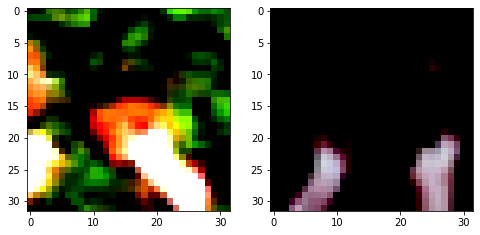

In [ ]:
tmp = unsup_loader.__iter__()
(image_i, image_y), _ = tmp.next()

# データの可視化
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

ax1.imshow(image_i[0].permute(1,2,0))
ax2.imshow(image_y[0].permute(1,2,0))

fig.show()

## ネットワークの準備

### ネットワークの定義
畳み込みニューラルネットワークの定義をします．\
今回は，11.knowledge_distillation，12.deep_mutual_learning，13.半教師付き学習で使用したネットワークと同様のものを利用します．

In [ ]:
class CNN(nn.Module):
    def __init__(self, widen_factor=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16*widen_factor, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16*widen_factor, 32*widen_factor, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(8*8*32*widen_factor, 1024*widen_factor)
        self.l2 = nn.Linear(1024*widen_factor, 1024*widen_factor)
        self.l3 = nn.Linear(1024*widen_factor, 10)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        h = self.pool(self.act(self.conv1(x)))
        h = self.pool(self.act(self.conv2(h)))
        h = h.view(h.size()[0], -1)
        h = self.act(self.l1(h))
        h = self.act(self.l2(h))
        h = self.l3(h)
        return h

### エンコーダ＋MLPの定義
学習対象のネットワークから出力層を取り除いた形のエンコーダとMLPから構成されるネットワークを定義します．\
今回は，学習対象のネットワークの「2層の畳み込み層＋3層の全結合層」における3層目の全結合層を出力層と捉えて，「2層の畳み込み層＋2層の全結合層」を自己教師あり学習により学習します．

まず，学習対象のネットワークの3層目の全結合層を，入力値をそのまま出力値とする層に置き換えます．\
次に，2層のMLPを定義します．\
また，各データの特徴量は，損失計算を簡単にするためにNサンプルずつの2つのTensorとして返します．

In [ ]:
# 入力をそのまま出力とする層の定義
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

# MLPを含めたネットワークの定義
class SimCLR(nn.Module):
    def __init__(self, encoder, projection_dim=128):
        super(SimCLR, self).__init__()
        self.encoder    = encoder     # ネットワーク
        self.n_features = encoder.l3.in_features  # ネットワークの３層目の全結合層の入力サイズ
        self.encoder.l3 = Identity()  # ネットワークの3層目の全結合層を変更（入力値をそのまま返すように変更）
        
        # MLPの定義
        self.projection_dim = projection_dim  # MLPの出力サイズ
        self.projector = nn.Sequential( nn.Linear(self.n_features, self.n_features, bias=False),
                                        nn.ReLU(),
                                        nn.Linear(self.n_features, self.projection_dim, bias=False) )

    def forward(self, x_i, x_j):
        # ネットワークへ入力
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)
        # ネットワークの出力した特徴量をMLPへ入力
        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        # ネットワークによる特徴量とMLPによる特徴量を出力するように設計
        return z_i, z_j

## 損失関数の定義
NT-Xent (Normalized Temperature-scaled CROSS entropy) 損失を実装します．
損失式は以下のようになります．

<img src="https://dl.dropboxusercontent.com/s/zztz70av6dgmwdj/SimCLR_loss.png" width = 40%>

このとき，この損失式は１つのデータ$z_i$に対する損失値を計算するものでした．\
基準とするデータ$z_i$によって分母の構成が変わるため，データ毎にこの損失式を計算する必要があります．\
プログラム上では，この損失式をforward関数内で３段階の工程から実現しています．\
ここでは例として，ミニバッチサイズを３として解説します．

データ増幅適用前のデータを(A, B, C)，データ増幅適用後のデータを(A1, A2, B1, B2, C1, C2)とします．\
自作データ増幅クラスとSimCLRクラスの設定から，最終的なネットワークの出力特徴量は，(A1, B1, C1)と(A2, B2, C2)の２つに分かれます．

---
１段階目では，全ての特徴量間の類似度を計算します．\
まず，２つに分かれている特徴量のTensorを結合します．\
結合は，「torch.cat」で行い，第一引数に結合したいTensor「(z_i, z_j)」を指定します．\
このとき，第一引数の１つ目に指定したTensor「z_i」の一番後ろに２つ目に指定したTensor「z_j」が結合されます．\
そのため，結合した後の特徴量の順番は，(A1，B1，C1，A2，B2，C2)となります．\
次に「self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature」で全ての特徴量間のコサイン類似度を計算します．\
これによって損失式内の「${\rm sim}()/T$」が計算されます．\
ここで作成されるTensorは，以下のような形で特徴量間の類似度が格納されています．

<img src="https://dl.dropboxusercontent.com/s/pzsr045caryivm1/loss_1.png" width = 55%>

---
２段階目では，損失計算に必要な類似度のみを取り出します．\
ポジティブペアの類似度は，(A1, A2)，(B1, B2)，(C1, C2)，(A2, A1)，(B2, B1)，(C2, C1)です．\
ポジティブペアの類似度の格納位置を確認すると，左上から右下にかけて斜めに格納されています．\
「torch.diag」を利用することで，第一引数で指定したTensorから，第二引数で指定した位置を基準として左上から右下にかけて斜めにTensor内の類似度を取り出します．\
第二引数によってどのように取り出し位置が変化するのかを各色で表します．\
Tensorの要素指定は「0」から始まるため，ミニバッチサイズと同じ値を指定することで，取り出したい要素を指定できます．

<img src="https://dl.dropboxusercontent.com/s/ztw8u2ya3b2y1lz/loss_2.png.png" width = 58%>

取り出した２つのTensor torch.diag(sim, 3)とtorch.diag(sim, -3)は，「torch.cat」によって１つのTensorにします．\
結合した後の類似度の順番は ( (A1, A2)，(B1, B2)，(C1, C2)，(A2, A1)，(B2, B1)，(C2, C1) ) となります．

次に「sim[self.mask].reshape(N, -1)」によって，全ての類似度を収納したTensorからポジティブペアの類似度や損失計算に不要な同じ特徴量間の類似度（例：A1とA1の類似度）を削除します．\
これにより，このTensorはネガティブペアの類似度のみを格納したTensorとなります．

最後に「torch.cat((positive_samples, negative_samples), dim=1)」によってポジティブペアの類似度とネガティブペアの類似度を１つのTensorにします．\
作成されたTensorは以下のような形となります．\
(0,0)，(1,0)，(2,0)といった縦の０番目の要素がポジティブペアの類似度（オレンジ背景），０番目以外の要素がネガティブペアの類似度（白背景）となっています．\
これにより，０番目の要素を取り出すことでNT-Xent損失の分子にあたる「${\rm sim}(z_i,z_j)/T$」，０～４番目の要素を取り出すことで分母にあたる「${\rm sim}(z_i,z_k)/T$」の計算結果を取り出すことができます．

<img src="https://dl.dropboxusercontent.com/s/g4izlda80i14696/loss_3.png.png.png" width = 55%>

---
３段階目では，損失計算を行います．\
損失計算には「nn.CrossEntropyLoss()」を利用します．
このクラスは，クロスエントロピー損失を計算します．\
クロスエントロピー損失の式は以下の通りです．

\begin{equation}
E=-\sum_i^{nclass} t_i \log y_i
\end{equation}

そのため，NT-Xent損失の式と見比べてどの計算に利用するのか疑問に思うかもしれません．\
「nn.CrossEntropyLoss()」クラスは，上記のようなクロスエントロピー損失のみを計算するクラスではなく，ソフトマックス関数の計算を内包したクラスです．
そのため，数式で表すと以下のようになります．

\begin{equation}
E=-\log(\frac{\exp(y_{label})}{\sum_i^{nclass} \exp(y_i)})
\end{equation}

このとき，$y_{label}$は正解クラス（第二引数により指定されたクラス）の確率値を表します．\
２段階目で作成したTensorは，０番目の要素がポジティブペアの類似度（NT-Xent損失の分子）であるため，第二引数として０を指定することでNT-Xent損失が計算されます．\
「torch.zeros(N).to(positive_samples.cuda()).long()」ではNT-Xent損失における基準となるデータ「$z_i$」の数分の０を指定するTensorを作成し，「self.criterion(logits, labels)」では損失を計算しています．\
このとき，「nn.CrossEntropyLoss(reduction="sum")」とinit関数で宣言しているため，基準となるデータ数分の損失値の総和となっています．\
今回は，平均値を最終的な損失とするため，データ数で除算します．



In [ ]:
class NT_Xent(nn.Module):
    def __init__(self, batch_size=128, temperature=1):
        super(NT_Xent, self).__init__()
        self.batch_size  = batch_size  # ミニバッチサイズ
        self.temperature = temperature  # 温度パラメータ

        self.mask = self.mask_correlated_samples(batch_size)  # マスクの作成
        self.criterion    = nn.CrossEntropyLoss(reduction="sum")  # クロスエントロピー(softmaxを内包)
        self.similarity_f = nn.CosineSimilarity(dim=2)  # コサイン類似度

    # 同一特徴量間の類似度とポジティブペアの類似度を削除するためのマスクの作成
    def mask_correlated_samples(self, batch_size):
        N    = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)  # 同一特徴量間の類似度が入っている位置の値を0に
        for i in range(batch_size):
            mask[i, batch_size+i] = 0  # ポジティブペアの類似度が入っている位置の値を0に
            mask[batch_size+i, i] = 0  # ポジティブペアの類似度が入っている位置の値を0に
        return mask

    def forward(self, z_i, z_j):
        # ------ 1 --------------------------------------------------------------------------
        N = 2 * self.batch_size
        z = torch.cat((z_i, z_j), dim=0)  # ネットワークの２つの出力を1つのTensorに
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature  # 全ての特徴量間の類似度を計算

        # ------ 2 --------------------------------------------------------------------------
        sim_i_j = torch.diag(sim,  self.batch_size)  # ポジティブペアの類似度(i->j))を抽出
        sim_j_i = torch.diag(sim, -self.batch_size)  # ポジティブペアの類似度(j->i))を抽出
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)  # ポジティブペアの類似度を1つのTensorに
        
        negative_samples = sim[self.mask].reshape(N, -1)  # ネガティブペアの類似度のみのTensorを作成

        logits = torch.cat((positive_samples, negative_samples), dim=1)  # ポジティブペアとネガティブペアの類似度を1つのテンソルに

        # ------ 3 --------------------------------------------------------------------------
        labels = torch.zeros(N).to(positive_samples.cuda()).long()  # ポジティブペアの類似度の位置を表すTensorを作成

        loss = self.criterion(logits, labels)  # 損失計算（総和）
        loss /= N  # データ数で除算（平均）
        return loss

## 学習条件の設定
ミニバッチサイズが大きい場合，１epochあたりのiteration数（ネットワークの更新回数）が少なくなります．\
そのため，一般的には，学習率や学習回数を大きく設定します．\
そこで，SimCLRではミニバッチサイズに合わせて学習率を調整しています．\
また，学習率が大きい場合，学習が不安定になります．\
そこで，最適化方法としてLARS (Layerwise Adaptive Rate Scaling)，学習率の調整テクニックとしてWarmupを利用します．

LARSは，ネットワークの層ごとに勾配の大きさに合わせて重みパラメータの更新量を調整する最適化方法です．\
Warmupは，学習初期から高い学習率とするのではなく，学習初期は小さな値として徐々に一定の値まで向上させるテクニックです．\
また，自己教師あり学習では，コサイン関数に基づいて学習率の減衰が行われます．

今回は，LARSは最初にインストールを行ったライブラリのものを使用し，Warmupとコサイン関数に基づいた学習率の調整は自作の関数により実現します．

In [ ]:
def adjust_learning_rate(optimizer, init_lr, epoch, max_epoch, warmup_epoch):
    if epoch <= warmup_epoch:
        # Warmupによる学習率の増幅
        cur_lr = init_lr * (epoch/warmup_epoch)
    else:
        # コサイン関数に基づいた学習率の減衰
        cur_lr = init_lr * 0.5 * (1. + math.cos(math.pi * (epoch-warmup_epoch) / (max_epoch-warmup_epoch)))

    # optimizerに格納されている学習率の値の変更
    for param_group in optimizer.param_groups:
        if 'fix_lr' in param_group and param_group['fix_lr']:
            param_group['lr'] = init_lr
        else:
            param_group['lr'] = cur_lr

今回は，学習回数を100 epoch，Warmupの期間を10 epochとします．\
Google colaboratory上では1 epochあたり約1分弱（100 epochで約2時間）の時間がかかります．\
そのため，学習回数は適宜調整して実行してください．

In [ ]:
# ネットワークの用意
encoder = CNN(widen_factor=1)  # ネットワークの定義
net = SimCLR(encoder)  # MLPを含めたネットワークの定義

# 学習回数の設定
NUM_EPOCH = 100

# Warmupの期間の設定
WARMUP_EPOCH = 10

# 学習率の設定
LR = 0.3*(BATCH_SIZE/256)

# 自己教師あり学習の損失式の設定
criterion = NT_Xent(BATCH_SIZE, 0.5)

# 最適化方法の設定
base_optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=10e-6)
optimizer = LARS(optimizer=base_optimizer, trust_coef=0.001)

### 学習率の推移の可視化
Warmupとコサイン関数に基づいた調整により，どのように学習率がどのように変化するのかを可視化します．

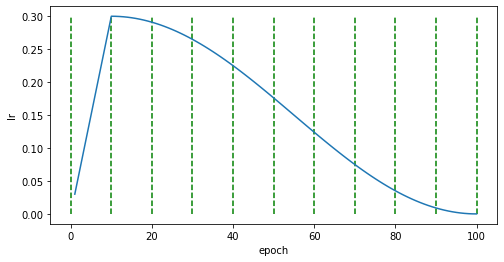

In [ ]:
import numpy as np

# 学習率の推移の可視化
def print_lr(LR, NUM_EPOCH):
    model = torch.nn.Linear(10, 3) # 仮のネットワークを作成
 
    # 可視化したい条件
    lr_list = list()
    base_optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=10e-6)
    optimizer = LARS(optimizer=base_optimizer, trust_coef=0.001)

    # 学習率の取得
    for epoch in range(1, NUM_EPOCH+1):
        adjust_learning_rate(optimizer, LR, epoch, NUM_EPOCH, WARMUP_EPOCH)
        pg = optimizer.param_groups[0]
        lr_list.append(pg['lr'])
        optimizer.step()
        #scheduler.step()

    # 学習率の推移を描画
    plt.figure(figsize=(8, 4))
    plt.plot([i+1 for i in range(len(lr_list))], lr_list)
    # 10 epoch刻みで縦線を描画
    plt.vlines([10*i for i in range(int((NUM_EPOCH/10)+1))], 0, np.array(lr_list).max(), "green", linestyles='dashed')
    # x軸とy軸のラベルを描画
    plt.xlabel('epoch')
    plt.ylabel('lr')
    plt.show()

# 学習率の推移の確認
print_lr(LR, NUM_EPOCH)

## ネットワークの学習
ネットワークを自己教師あり学習します．

In [ ]:
# ネットワークをGPUへ
net = net.cuda()

# ネットワークを学習モードへ変更
net.train()

start = time()
for epoch in range(1, NUM_EPOCH+1):
    # ログ用の設定
    sum_loss = 0.0

    # 学習率の調整
    adjust_learning_rate(optimizer, LR, epoch, NUM_EPOCH, 10)
    
    for (image_i, image_y), _ in unsup_loader:
        # ラベルなしデータをGPUへ
        image_i = image_i.cuda()
        image_y = image_y.cuda()
        
        # ラベルなしデータをネットワークへ入力
        z_i, z_j = net(image_i, image_y)
        
        # 損失の計算
        loss = criterion(z_i, z_j)
        
        # パラメータの更新
        net.zero_grad()
        loss.backward()
        optimizer.step()
        
        # ログ用に損失値を取得
        sum_loss += loss.item()
       
    # ログの表示
    if (epoch%5 == 0) or (epoch == NUM_EPOCH):
        print(f"epoch: {epoch},\
                mean loss: {round(sum_loss/len(unsup_loader), 3)},\
                elapsed_time :{round(time()-start, 2)}")

/usr/local/lib/python3.7/dist-packages/torchlars/lars.py:140: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  p.grad.add_(weight_decay, p.data)


epoch: 5,                mean loss: 5.273,                elapsed_time :388.55
epoch: 10,                mean loss: 5.17,                elapsed_time :777.28
epoch: 15,                mean loss: 5.103,                elapsed_time :1167.04
epoch: 20,                mean loss: 5.054,                elapsed_time :1555.77
epoch: 25,                mean loss: 5.024,                elapsed_time :1936.92
epoch: 30,                mean loss: 5.001,                elapsed_time :2313.25
epoch: 35,                mean loss: 4.98,                elapsed_time :2688.25
epoch: 40,                mean loss: 4.969,                elapsed_time :3072.51
epoch: 45,                mean loss: 4.954,                elapsed_time :3451.83
epoch: 50,                mean loss: 4.945,                elapsed_time :3826.79
epoch: 55,                mean loss: 4.933,                elapsed_time :4202.7
epoch: 60,                mean loss: 4.926,                elapsed_time :4577.59
epoch: 65,                mean los

## 自己教師あり学習したネットワークの保存

In [ ]:
torch.save(net.encoder.to('cpu').state_dict(), './cifar100_pre_train.pth')

## 自己教師あり学習したネットワークの評価

### データセットの用意
下流タスクとして使用するデータセットを定義します．\
今回は，下流タスクとしてランダムに選んだ1,000サンプルのデータから学習します．

In [ ]:
# 学習用データに対するデータ増幅
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# 評価用データに対するデータ増幅
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# 学習用データ
trainset = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=True,  download=True, transform=train_transform)

# 評価用データ
testset  = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=False, download=True, transform=test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dataset/CIFAR-10/cifar-10-python.tar.gz to ./dataset/CIFAR-10
Files already downloaded and verified


In [ ]:
# StratifiedShuffleSplit：データをシャッフルして分割
sss = StratifiedShuffleSplit(n_splits=1, test_size=1000, random_state=0)

# list(range(len(total_trainset)))：データidのリスト，total_trainset.targets：データidに対応するラベル
sss = sss.split(list(range(len(trainset))), trainset.targets)

# 分割後のデータidを取得
_, label_idx = next(sss)

In [ ]:
# 学習用データセットを作成
train_subset = Subset(trainset, label_idx)
labels = [trainset.targets[idx] for idx in label_idx]
train_subset.train_labels = labels

In [ ]:
print("データ数")
print("教師ありデータ：", len(train_subset))

データ数
教師ありデータ： 1000


In [ ]:
# 学習用データのDataloader
train_loader = torch.utils.data.DataLoader(train_subset, 
                                           batch_size=16, 
                                           shuffle=True,
                                           num_workers=16,
                                           pin_memory=True,
                                           drop_last=True)

# 評価用データのDataloader
test_loader  = torch.utils.data.DataLoader(testset, 
                                           batch_size=16,
                                           shuffle=False, 
                                           num_workers=16, 
                                           pin_memory=True, 
                                           drop_last=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 乱数により初期化したネットワーク
自己教師あり学習による事前学習した場合の結果と比較するために，乱数により初期化したネットワークを教師あり学習します．\
また，５epochごとに評価用データを用いてネットワークの評価を行います．

In [ ]:
# ネットワークの設定
sup_net = CNN(widen_factor=1)

# 最適化方法の設定
optimizer = torch.optim.SGD(sup_net.parameters(), lr=0.01, momentum=0.9)

# 損失式の設定
criterion = torch.nn.CrossEntropyLoss()

# エポック数の設定
NUM_EPOCH = 30

# ネットワークをGPUへ
sup_net = sup_net.cuda()

start = time()
for epoch in range(1, NUM_EPOCH+1):
    # ネットワークの学習 ----------------------------------------------------------
    # ネットワークを学習モードへ変更
    sup_net.train()

    # ログ用の設定
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        # 学習用データをGPUへ
        image = image.cuda()
        label = label.cuda()
        
        # 学習用データをネットワークへ入力
        logits = sup_net(image)

        # 損失の計算
        loss = criterion(logits, label)
        
        # パラメータの更新
        sup_net.zero_grad()
        loss.backward()
        optimizer.step()
        
        # ログ用に損失値と正解したデータ数を取得
        sum_loss += loss.item()
        pred   = torch.argmax(logits, dim=1)
        count += torch.sum(pred == label)
        
    # ログの表示
    print(f"epoch: {epoch},\
            mean loss: {round(sum_loss/len(train_loader), 3)},\
            mean accuracy: {round(count.item()/len(train_loader.dataset), 2)},\
            elapsed_time :{round(time()-start, 2)}")

    # ネットワークの評価 ----------------------------------------------------------
    if (epoch%5 == 0) or (epoch == NUM_EPOCH):  # 5 epoch毎に評価
        # ネットワークを評価モードへ変更
        sup_net.eval()

        # 評価の実行
        count = 0
        with torch.no_grad():
            for image, label in test_loader:
                # 評価用データをGPUへ
                image = image.cuda()
                label = label.cuda()

                # 評価用データをネットワークへ入力
                logits = sup_net(image)

                # 正解したデータ数を取得
                pred = torch.argmax(logits, dim=1)
                count += torch.sum(pred == label)

        # 評価結果の表示
        print(f"test accuracy: {count.item()/len(test_loader.dataset)}")

epoch: 1,            mean loss: 2.267,            mean accuracy: 0.15,            elapsed_time :1.6
epoch: 2,            mean loss: 2.064,            mean accuracy: 0.23,            elapsed_time :3.18
epoch: 3,            mean loss: 1.912,            mean accuracy: 0.3,            elapsed_time :4.82
epoch: 4,            mean loss: 1.761,            mean accuracy: 0.35,            elapsed_time :6.42
epoch: 5,            mean loss: 1.594,            mean accuracy: 0.42,            elapsed_time :8.04
test accuracy: 0.3635
epoch: 6,            mean loss: 1.4,            mean accuracy: 0.47,            elapsed_time :14.05
epoch: 7,            mean loss: 1.193,            mean accuracy: 0.54,            elapsed_time :15.67
epoch: 8,            mean loss: 1.013,            mean accuracy: 0.64,            elapsed_time :17.24
epoch: 9,            mean loss: 0.719,            mean accuracy: 0.74,            elapsed_time :18.83
epoch: 10,            mean loss: 0.496,            mean accuracy: 0.8

### 自己教師あり学習により事前学習したネットワーク
自己教師あり学習により事前学習したネットワークを学習します．

自己教師あり学習は，学習に多くの時間を必要とするため，いくつかの自己教師あり学習した重みパラメータを用意しました．
使用したい場合は，以下のプログラムから重みパラメータのダウンロードを行い，次の「自己教師あり学習した重みパラメータの指定」のPATHを変更して実行してください．


In [ ]:
import requests

# ネットワーク：widen_factor=1, エポック数：300, ミニバッチサイズ：256
#res = requests.get("https://www.dropbox.com/s/ux6f8gz88bzg9qe/cifar100_wf1_300epoch_256batch.pth?dl=1")
#with open(f"cifar100_wf1_300epoch_256batch.pth", 'wb') as f:
#    f.write(res.content)

# ネットワーク：widen_factor=1, エポック数：300, ミニバッチサイズ：512
#res = requests.get("https://www.dropbox.com/s/e31vr8o57zyqlfe/cifar100_wf1_300epoch_512batch.pth?dl=1")
#with open(f"cifar100_wf1_300epoch_512batch.pth", 'wb') as f:
#    f.write(res.content)

# ネットワーク：widen_factor=1, エポック数：100, ミニバッチサイズ：1024
#res = requests.get("https://www.dropbox.com/s/a6h9n4m8007biwm/cifar100_wf1_100epoch_1024batch.pth?dl=1")
#with open(f"cifar100_wf1_100epoch_1024batch.pth", 'wb') as f:
#    f.write(res.content)

# ネットワーク：widen_factor=1, エポック数：300, ミニバッチサイズ：1024
#res = requests.get("https://www.dropbox.com/s/oi1p4kwd1mjij53/cifar100_wf1_300epoch_1024batch.pth?dl=1")
#with open(f"cifar100_wf1_300epoch_1024batch.pth", 'wb') as f:
#    f.write(res.content)

# ネットワーク：widen_factor=1, エポック数：1000, ミニバッチサイズ：1024
#res = requests.get("https://www.dropbox.com/s/u46wsbgtgwqr7k2/cifar100_wf1_1000epoch_1024batch.pth?dl=1")
#with open(f"cifar100_wf1_1000epoch_1024batch.pth", 'wb') as f:
#    f.write(res.content)

#### 自己教師あり学習した重みパラメータの指定

In [ ]:
weight_path = './cifar100_pre_train.pth'

#### fine-tuning

In [ ]:
# ネットワークの設定
ssl_net = CNN(widen_factor=1)  # ネットワークの用意
msg = ssl_net.load_state_dict(torch.load(weight_path), strict=False)  # 重みパラメータの読み込み
print(msg)

# 最適化方法の設定
optimizer = torch.optim.SGD(ssl_net.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

# エポック数の設定
NUM_EPOCH = 30

# ネットワークをGPUへ
ssl_net = ssl_net.cuda()

start = time()
for epoch in range(1, NUM_EPOCH+1):
    # ネットワークの学習 ----------------------------------------------------------
    # ネットワークを学習モードへ変更
    ssl_net.train()

    # ログ用の設定
    sum_loss = 0.0
    count = 0

    for image, label in train_loader:
        # 学習用データをGPUへ
        image = image.cuda()
        label = label.cuda()

        # 学習用データをネットワークへ入力
        logits = ssl_net(image)

        # 損失の計算
        loss = criterion(logits, label)

        # パラメータの更新
        ssl_net.zero_grad()
        loss.backward()
        optimizer.step()

        # ログ用に損失値と正解したデータ数を取得
        sum_loss += loss.item()
        pred   = torch.argmax(logits, dim=1)
        count += torch.sum(pred == label)

    # ログの表示
    print(f"epoch: {epoch},\
            mean loss: {round(sum_loss/len(train_loader), 3)},\
            mean accuracy: {round(count.item()/len(train_loader.dataset), 2)},\
            elapsed_time :{round(time()-start, 2)}")


    # ネットワークの評価 ----------------------------------------------------------
    if (epoch%5 == 0) or (epoch == NUM_EPOCH):  # 5 epoch毎に評価
        # ネットワークを評価モードへ変更
        ssl_net.eval()

        # 評価の実行
        count = 0
        with torch.no_grad():
            for image, label in test_loader:
                # 評価用データをGPUへ
                image = image.cuda()
                label = label.cuda()

                # 評価用データをネットワークへ入力
                logits = ssl_net(image)

                # 正解したデータ数を取得
                pred = torch.argmax(logits, dim=1)
                count += torch.sum(pred == label)
                
        # 評価結果の表示
        print(f"test accuracy: {count.item()/len(test_loader.dataset)}")

_IncompatibleKeys(missing_keys=['l3.weight', 'l3.bias'], unexpected_keys=[])
epoch: 1,            mean loss: 2.221,            mean accuracy: 0.16,            elapsed_time :1.67
epoch: 2,            mean loss: 1.914,            mean accuracy: 0.3,            elapsed_time :3.24
epoch: 3,            mean loss: 1.722,            mean accuracy: 0.37,            elapsed_time :4.83
epoch: 4,            mean loss: 1.519,            mean accuracy: 0.43,            elapsed_time :6.4
epoch: 5,            mean loss: 1.288,            mean accuracy: 0.53,            elapsed_time :7.95
test accuracy: 0.4036
epoch: 6,            mean loss: 1.085,            mean accuracy: 0.6,            elapsed_time :14.13
epoch: 7,            mean loss: 0.892,            mean accuracy: 0.69,            elapsed_time :15.7
epoch: 8,            mean loss: 0.598,            mean accuracy: 0.8,            elapsed_time :17.31
epoch: 9,            mean loss: 0.379,            mean accuracy: 0.86,            elapsed_time 

#### 転移学習

In [ ]:
# 出力層のみのネットワーク
class LogisticRegression(nn.Module):
    def __init__(self, n_features, n_classes):
        super(LogisticRegression, self).__init__()
        self.model = nn.Linear(n_features, n_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
# ネットワークの設定
encoder = CNN(widen_factor=1)  # ネットワークの用意
encoder.l3 = Identity()  # ネットワークの3層目の全結合層を変更（入力値をそのまま返すように変更）
encoder.load_state_dict(torch.load(weight_path))  # 重みパラメータの読み込み

net_fc = LogisticRegression(encoder.l2.out_features, 10)  # 出力層のみネットワークの用意

# 最適化方法の設定
optimizer = torch.optim.Adam(net_fc.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# エポック数の設定
NUM_EPOCH = 30

# ネットワークと出力層をGPUへ
encoder = encoder.cuda()
net_fc  = net_fc.cuda()

# ネットワークを評価モードへ変更
encoder.eval()

start = time()
for epoch in range(1, NUM_EPOCH+1):
    # 出力層の学習 ---------------------------------------------------------------
    # 出力層を学習用モードへ変更
    net_fc.train()

    # ログ用の設定
    sum_loss = 0.0
    count = 0

    for image, label in train_loader:
        # 学習用データをGPUへ
        image = image.cuda()
        label = label.cuda()

        # 学習用データをネットワークへ入力
        with torch.no_grad():
            h = encoder(image)

        # ネットワークの抽出した特徴量を出力層へ入力
        h = h.detach()  # 計算グラフのカット
        y = net_fc(h)

        # 損失の計算
        loss = criterion(y, label)

        # パラメータの更新
        net_fc.zero_grad()
        loss.backward()
        optimizer.step()

        # ログ用に損失値と正解したデータ数を取得
        sum_loss += loss.item()
        pred   = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

    # ログの表示
    print(f"epoch: {epoch},\
            mean loss: {round(sum_loss/len(train_loader), 3)},\
            mean accuracy: {round(count.item()/len(train_loader.dataset), 2)},\
            elapsed_time : {round(time()-start, 2)}")

    # ネットワーク+出力層の評価 ----------------------------------------------------
    if (epoch%5 == 0) or (epoch == NUM_EPOCH):  # 5 epoch毎に評価
        # ネットワークを評価モードへ変更
        net_fc.eval()

        # 評価の実行
        count = 0
        with torch.no_grad():
            for image, label in test_loader:
                # 評価用データをGPUへ
                image = image.cuda()
                label = label.cuda()

                # 評価用データをネットワーク+出力層へ入力
                h = encoder(image)
                y = net_fc(h)

                # 正解したデータ数を取得
                pred = torch.argmax(y, dim=1)
                count += torch.sum(pred == label)

        # 評価結果の表示
        print(f"test accuracy: {count.item()/len(test_loader.dataset)}")

epoch: 1,            mean loss: 1.909,            mean accuracy: 0.32,            elapsed_time : 1.5
epoch: 2,            mean loss: 1.479,            mean accuracy: 0.49,            elapsed_time : 3.02
epoch: 3,            mean loss: 1.336,            mean accuracy: 0.55,            elapsed_time : 4.51
epoch: 4,            mean loss: 1.222,            mean accuracy: 0.59,            elapsed_time : 6.47
epoch: 5,            mean loss: 1.155,            mean accuracy: 0.61,            elapsed_time : 8.01
test accuracy: 0.4913
epoch: 6,            mean loss: 1.084,            mean accuracy: 0.63,            elapsed_time : 14.28
epoch: 7,            mean loss: 1.035,            mean accuracy: 0.66,            elapsed_time : 15.76
epoch: 8,            mean loss: 0.983,            mean accuracy: 0.68,            elapsed_time : 17.24
epoch: 9,            mean loss: 0.943,            mean accuracy: 0.7,            elapsed_time : 18.74
epoch: 10,            mean loss: 0.903,            mean ac

# 課題
1. 自己教師あり学習の学習回数（エポック数）を変更してみましょう
2. 自己教師あり学習のミニバッチサイズを変更してみましょう
3. 下流タスクのデータ数を変更してみましょう